In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

In [2]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [3]:
env_id = "SeaquestNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [4]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [142]:
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = ALGOS['a2c']('CnnPolicy', env).policy
        self.reward_net = nn.Linear(512, 1).to(device)
        self.device = device
    
    def forward(self, obs):
        obs_transposed = VecTransposeImage.transpose_image(obs)
        latent, _, _= self.ac_model._get_latent(th.tensor(obs_transposed).to(self.device))
        return self.reward_net(latent)
    
    def f(self, obs):
        latent, _, _= self.ac_model._get_latent(obs)
        return self.reward_net(latent)
    
    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False
            

In [29]:
def create_circular_mask(h, w, center, radius=5):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
    mask = dist_from_center <= radius
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

def max_k_and_values(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return list(zip(items, values))

loss_fn = th.nn.MSELoss()
def policy_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_transposed = VecTransposeImage.transpose_image(np.copy(obs))
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    baseline = model.policy.action_net(latent)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_transposed[0, k, :, :]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_transposed[0, k, :, :] = img*(1 - M) + A*M
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    modified = model.policy.action_net(latent)
    return loss_fn(baseline, modified).item()

def value_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_transposed = VecTransposeImage.transpose_image(np.copy(obs))
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    baseline = model.policy.value_net(latent)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_transposed[0, k, :, :]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_transposed[0, k, :, :] = img*(1 - M) + A*M
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    modified = model.policy.value_net(latent)
    return loss_fn(baseline, modified).item()

def reward_model_saliency(model: RewardModel, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_copy[0, :, :, k]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_copy[0, :, :, k] = img*(1 - M) + A*M
    modified = model(obs_copy)
    return loss_fn(baseline, modified).item()

def invert_preprocessing(loc):
    x, y = loc
    return (int(210/84*x), int(160/84*y))

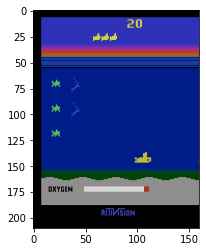

In [14]:
obs = env.reset()
for i in range(1500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        break
plt.imshow(env.get_images()[0])

In [15]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/seaquest_rm_v1.pt"))

<All keys matched successfully>

In [37]:
obs = env.reset()
for i in range(500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        break

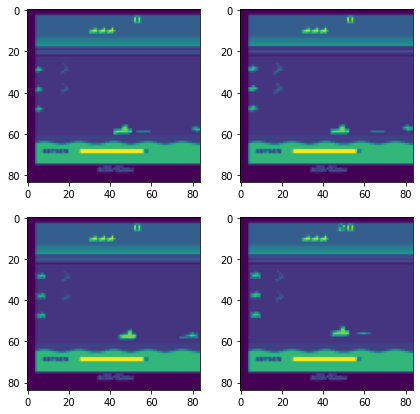

In [38]:
plt.figure(figsize=(7, 7))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.imshow(obs[0, :, :, k])

In [39]:
with th.no_grad():
    print(rm(obs).item())

0.9727372527122498


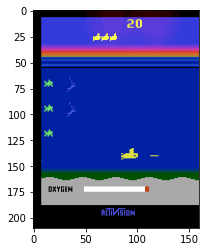

In [41]:
radius = 10
stride = 4

pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
# max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

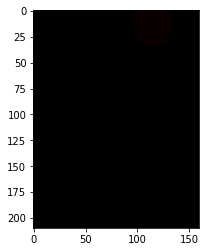

In [42]:
plt.imshow(spot)

In [43]:
pairs

[((4, 40), 0.0036493923980742693),
 ((8, 56), 0.0011581964790821075),
 ((4, 36), 0.001095030689612031),
 ((4, 44), 0.0010104612447321415),
 ((0, 44), 0.000911475159227848),
 ((0, 36), 0.0006516033899970353),
 ((0, 60), 0.0006251060985960066),
 ((0, 64), 0.0006044079782441258),
 ((4, 64), 0.0005978260305710137),
 ((4, 60), 0.0005840958328917623)]

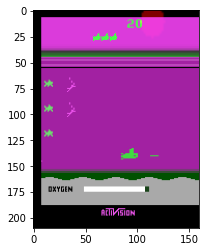

In [44]:
radius = 6
stride = 4

locs = max_k(5, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
for loc in locs:
    spot = 0.5*create_circular_mask(84, 84, center=loc, radius=radius)
    spot = skimage.transform.resize(spot, (210, 160))
    screenshot[:, :, 0] = spot + (1-spot)*screenshot[:, :, 2]
#     screenshot[:, :, 2] = spot + (1-spot)*screenshot[:, :, 2]
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

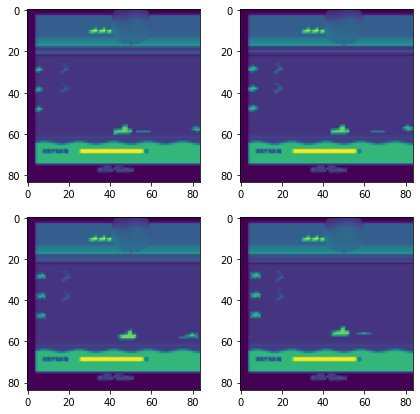

In [55]:
loc = (7, 50)
radius = 10

obs_copy = np.copy(obs)
M = create_circular_mask(84, 84, center=loc, radius=radius)
for k in range(4):
    img = obs_copy[0, :, :, k]
    A = scipy.ndimage.gaussian_filter(img, 3)
    obs_copy[0, :, :, k] = img*(1 - M) + A*M
    
plt.figure(figsize=(7, 7))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.imshow(obs_copy[0, :, :, k])

In [56]:
rm(obs_copy)

tensor([[0.9887]], device='cuda:0', grad_fn=<AddmmBackward>)

In [57]:
obs = env.reset()
for i in range(50):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)

In [59]:
rm(obs)

tensor([[0.0189]], device='cuda:0', grad_fn=<AddmmBackward>)

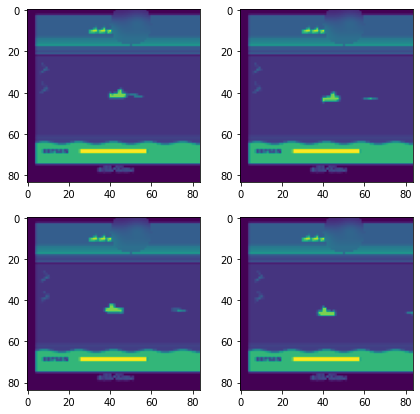

In [60]:
loc = (7, 50)
radius = 10

obs_copy = np.copy(obs)
M = create_circular_mask(84, 84, center=loc, radius=radius)
for k in range(4):
    img = obs_copy[0, :, :, k]
    A = scipy.ndimage.gaussian_filter(img, 3)
    obs_copy[0, :, :, k] = img*(1 - M) + A*M
    
plt.figure(figsize=(7, 7))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.imshow(obs_copy[0, :, :, k])

In [61]:
rm(obs_copy)

tensor([[0.3595]], device='cuda:0', grad_fn=<AddmmBackward>)

# Okay so during non-reward states, score is salient, but it is not very salient for reward states.

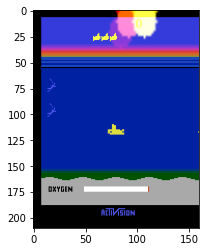

In [65]:
radius = 6
stride = 4

pairs = max_k_and_values(5, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
# max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

In [67]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


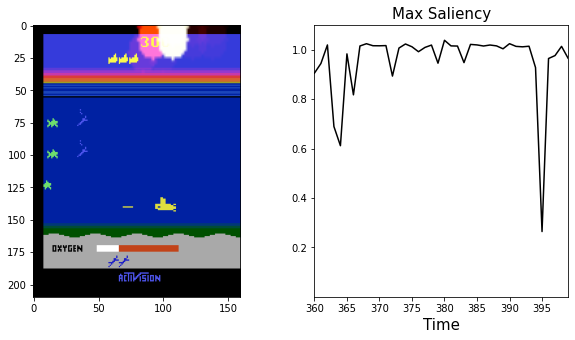

In [68]:
radius = 6
stride = 4

TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 5))
# ax.set_title(f"mnist: {top_str}", fontsize=15)
# ax.set_ylabel('Sensitivity / Degeneracy', fontsize=15)
# ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize=15)
# ax.set_xlim([-1, 17])
# ax.set_ylim([0, 22000])
ax2.set_xlabel("Time", fontsize=15)
ax2.set_title("Max Saliency", fontsize=15)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
timeseries = ax2.plot([], [], c='black')[0]
max_saliencies = []
with writer.saving(fig, "../videos/seaquest/seaquest_reward_model_saliency_hot_timeseries.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        max_value = pairs[0][1]
        max_saliencies.append(max_value)
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        ax2.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
#         ax2.set_yscale('log')
        ax2.set_ylim(0.0001, 1.1)
        timeseries.set_data(list(range(i+1))[-40:], max_saliencies[-40:])
        writer.grab_frame()
#         plt.subplots_adjust(wspace=0.2)

In [69]:
obs_copy = np.copy(obs)

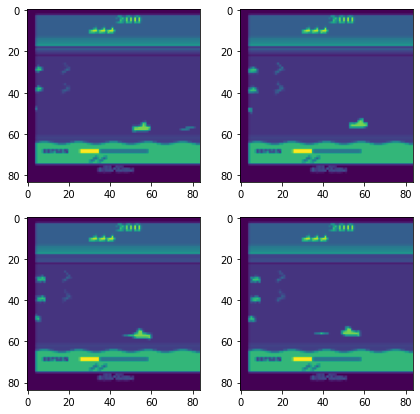

In [72]:
plt.figure(figsize=(7, 7))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.imshow(obs[0, :, :, k])

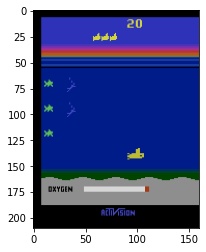

In [101]:
obs = env.reset()
for i in range(1500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        break
plt.imshow(env.get_images()[0])

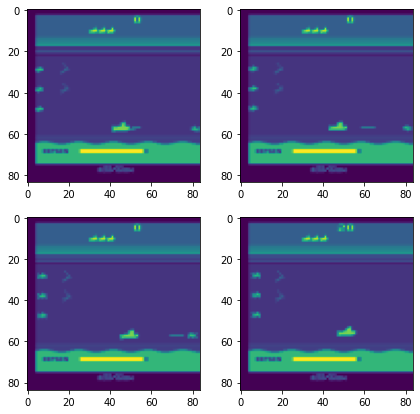

In [102]:
plt.figure(figsize=(7, 7))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.imshow(obs[0, :, :, k])

In [103]:
rm(obs)

tensor([[0.9721]], device='cuda:0', grad_fn=<AddmmBackward>)

In [107]:
obs_copy.shape

(1, 84, 84, 4)

In [108]:
obs_copy = np.copy(obs)
obs_copy[0, :, :, 3] = obs_copy[0, :, :, 2]

In [112]:
rm(obs_copy)

tensor([[0.0245]], device='cuda:0', grad_fn=<AddmmBackward>)

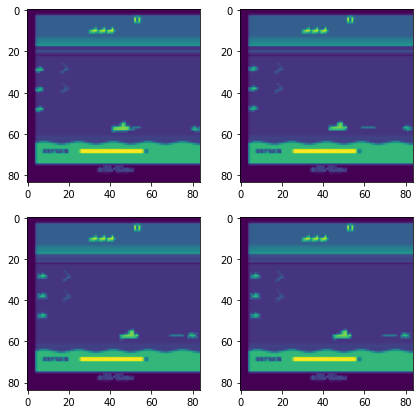

In [110]:
plt.figure(figsize=(7, 7))
for k in range(4):
    plt.subplot(2, 2, k+1)
    plt.imshow(obs_copy[0, :, :, k])

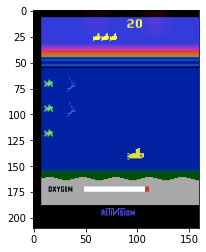

In [113]:
radius = 6
stride = 4

pairs = max_k_and_values(5, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
# max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

In [114]:
pairs

[((4, 32), 0.0009065978229045868),
 ((0, 32), 0.000690571847371757),
 ((0, 60), 0.0005571645451709628),
 ((4, 60), 0.0005510863848030567),
 ((4, 64), 0.00052365887677297)]

# Okay during a positive-reward timestep, although no individual region in the frame stack is salient, setting the final frame equal to the previous frame destroys the reward information.

In [178]:
def transpose(obs):
    return VecTransposeImage.transpose_image(obs)

def invert_transpose(obs_transposed):
    return VecTransposeImage.transpose_image(VecTransposeImage.transpose_image(obs_transposed))

In [179]:
def visu_loss_fn(img, y, lbda=1.0, minimize=True):
    """Note that img is a transposed img of shape (1, 4, 84, 84)"""
    if minimize:
        return th.sum(y) + lbda*th.mean((img[0, 2, :, :]-img[0, 3, :, :])**2)
    else:
        return -th.sum(y) + lbda*th.mean((img[0, 2, :, :]-img[0, 3, :, :])**2)

In [190]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/seaquest_rm_v1.pt"))

<All keys matched successfully>

In [201]:
transpose(obs).shape

(1, 4, 84, 84)

In [223]:
obs_copy = np.copy(transpose(obs))
baseline = th.from_numpy(obs_copy).to(dtype)
# obs_copy[0, 3, :, :] = baseline[0, 2, :, :]

In [224]:
img = th.from_numpy(obs_copy).to(dtype)
img.requires_grad = True

In [225]:
feature_optim = th.optim.Adam([img], lr=0.05)
for _ in range(2000):
    feature_optim.zero_grad()
    batch_loss = visu_loss_fn(img.to(device), rm.f(img.to(device)), lbda=0.02)
    batch_loss.backward()
    feature_optim.step()
    with th.no_grad():
        img[0, 0:3, :, :] = baseline[0, 0:3, :, :]

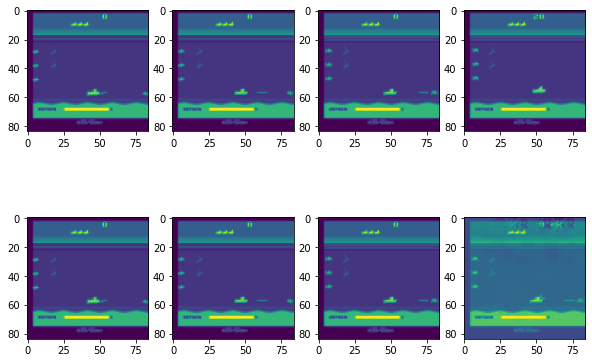

In [226]:
plt.figure(figsize=(10, 7))
for k in range(4):
    plt.subplot(2, 4, k+1)
    plt.imshow(invert_transpose(baseline.detach().numpy())[0, :, :, k])
    plt.subplot(2, 4, 4+k+1)
    plt.imshow(invert_transpose(img.detach().numpy())[0, :, :, k])

In [227]:
rm.f(img.to(device))

tensor([[-1.8961]], device='cuda:0', grad_fn=<AddmmBackward>)

In [244]:
def reward_model_saliency_last(model: RewardModel, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    img = obs_copy[0, :, :, 3]
    A = scipy.ndimage.gaussian_filter(img, 3)
    obs_copy[0, :, :, 3] = img*(1 - M) + A*M
    modified = model(obs_copy)
    return loss_fn(baseline, modified).item()

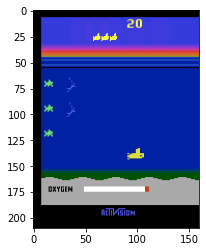

In [234]:
radius = 6
stride = 4

pairs = max_k_and_values(5, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency_last(rm, obs, e, radius=radius))
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
# max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

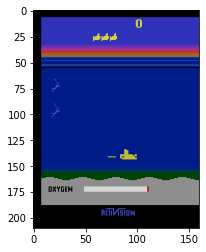

In [235]:
obs = env.reset()
for i in range(50):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
plt.imshow(env.get_images()[0])

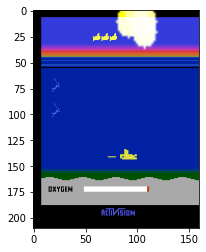

In [236]:
radius = 6
stride = 4

pairs = max_k_and_values(5, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency_last(rm, obs, e, radius=radius))
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
# max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

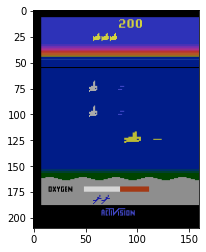

In [238]:
count = 0
obs = env.reset()
for i in range(500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        count += 1
    if count == 10:
        break
plt.imshow(env.get_images()[0])

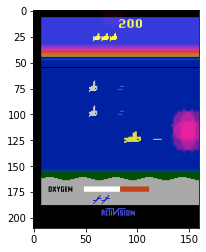

In [243]:
radius = 6
stride = 4

pairs = max_k_and_values(5, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
# max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


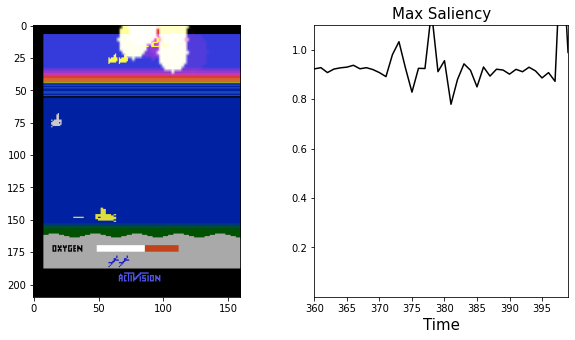

In [245]:
radius = 6
stride = 4

TIMESTEPS = 400

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 5))
# ax.set_title(f"mnist: {top_str}", fontsize=15)
# ax.set_ylabel('Sensitivity / Degeneracy', fontsize=15)
# ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize=15)
# ax.set_xlim([-1, 17])
# ax.set_ylim([0, 22000])
ax2.set_xlabel("Time", fontsize=15)
ax2.set_title("Max Saliency", fontsize=15)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
timeseries = ax2.plot([], [], c='black')[0]
max_saliencies = []
with writer.saving(fig, "../videos/seaquest/seaquest_reward_model_saliency_hot_timeseries_last.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency_last(rm, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        max_value = pairs[0][1]
        max_saliencies.append(max_value)
        for loc, value in pairs:
            r, g, b, a = matplotlib.cm.hot(value)
            region = create_circular_mask(84, 84, center=loc, radius=radius)
            region = skimage.transform.resize(region, (210, 160))
            spot = np.zeros((210, 160, 3))
            spot[:, :, 0] = r * region
            spot[:, :, 1] = g * region
            spot[:, :, 2] = b * region
            spot = spot * a
            screenshot = spot + (1-spot)*screenshot
            screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        ax2.set_xlim(list(range(i+1))[-40:][0], list(range(i+1))[-40:][-1])
#         ax2.set_yscale('log')
        ax2.set_ylim(0.0001, 1.1)
        timeseries.set_data(list(range(i+1))[-40:], max_saliencies[-40:])
        writer.grab_frame()
#         plt.subplots_adjust(wspace=0.2)

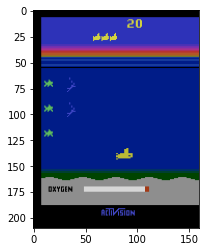

In [246]:
count = 0
obs = env.reset()
for i in range(500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        count += 1
    if count == 1:
        break
plt.imshow(env.get_images()[0])

In [249]:
rm(obs)

tensor([[0.9764]], device='cuda:0', grad_fn=<AddmmBackward>)

In [250]:
obs[0, :, :, 3] = obs[0, :, :, 2]

In [251]:
rm(obs)

tensor([[0.0242]], device='cuda:0', grad_fn=<AddmmBackward>)

# So the state of the final frame in the stack is super relevant, but there is no single region which is particularly salient to it.

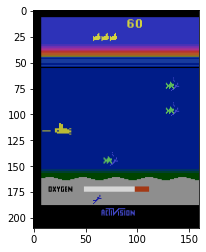

In [252]:
count = 0
obs = env.reset()
for i in range(150):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
#     if reward[0]:
#         count += 1
#     if count == 1:
#         break
plt.imshow(env.get_images()[0])

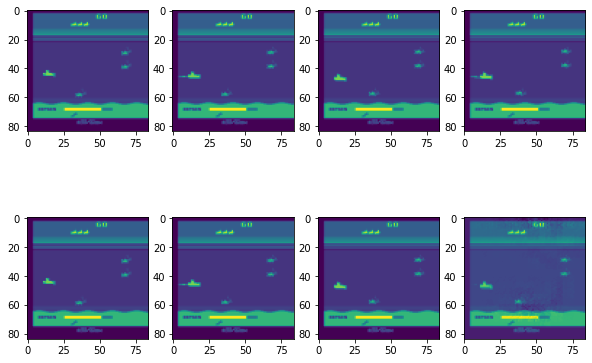

In [256]:
obs_copy = np.copy(transpose(obs))
baseline = th.from_numpy(obs_copy).to(dtype)
# obs_copy[0, 3, :, :] = baseline[0, 2, :, :]

img = th.from_numpy(obs_copy).to(dtype)
img.requires_grad = True

feature_optim = th.optim.Adam([img], lr=0.05)
for _ in range(2000):
    feature_optim.zero_grad()
    batch_loss = visu_loss_fn(img.to(device), rm.f(img.to(device)), lbda=0.015, minimize=False)
    batch_loss.backward()
    feature_optim.step()
    with th.no_grad():
        img[0, 0:3, :, :] = baseline[0, 0:3, :, :]
        
plt.figure(figsize=(10, 7))
for k in range(4):
    plt.subplot(2, 4, k+1)
    plt.imshow(invert_transpose(baseline.detach().numpy())[0, :, :, k])
    plt.subplot(2, 4, 4+k+1)
    plt.imshow(invert_transpose(img.detach().numpy())[0, :, :, k])

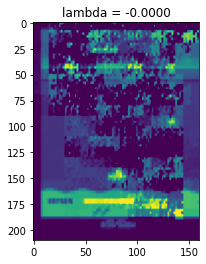

In [271]:
radius = 7
stride = 6

lambdas = [1, 0.5, 0.2, 0.1] + list(np.arange(0.05, -0.001, -0.001))
TIMESTEPS = len(lambdas)

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=2, metadata=metadata)

fig, ax = plt.subplots(1, 1)

count = 0
obs = env.reset()
for i in range(150):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward[0]:
        count += 1
    if count == 8:
        break
plt.imshow(env.get_images()[0])

imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "../videos/seaquest/seaquest_reward_model_visu_sweep_min.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
#         action, _states = model.predict(obs, deterministic=False)
#         obs, reward, done, info = env.step(action)
#         if done:
#             break
        obs_copy = np.copy(transpose(obs))
        baseline = th.from_numpy(obs_copy).to(dtype)
        # obs_copy[0, 3, :, :] = baseline[0, 2, :, :]
        img = th.from_numpy(obs_copy).to(dtype)
        img.requires_grad = True
        feature_optim = th.optim.Adam([img], lr=0.05)
        for _ in range(2000):
            feature_optim.zero_grad()
            batch_loss = visu_loss_fn(img.to(device), rm.f(img.to(device)), lbda=lambdas[i], minimize=True)
            batch_loss.backward()
            feature_optim.step()
            with th.no_grad():
                img[0, 0:3, :, :] = baseline[0, 0:3, :, :]
        imshow.set_data(invert_transpose(img.detach().numpy())[0, :, :, k])
        ax.set_title("lambda = {:.4f}".format(lambdas[i]))
        writer.grab_frame()

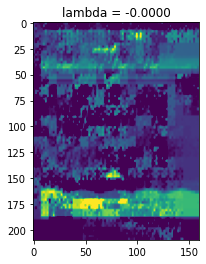

In [272]:
radius = 7
stride = 6

lambdas = [1, 0.5, 0.2, 0.1] + list(np.arange(0.05, -0.001, -0.001))
TIMESTEPS = len(lambdas)

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=2, metadata=metadata)

fig, ax = plt.subplots(1, 1)

count = 0
obs = env.reset()
for i in range(300):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if i > 200 and not reward[0]:
        break
plt.imshow(env.get_images()[0])

imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "../videos/seaquest/seaquest_reward_model_visu_sweep_max.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
#         action, _states = model.predict(obs, deterministic=False)
#         obs, reward, done, info = env.step(action)
#         if done:
#             break
        obs_copy = np.copy(transpose(obs))
        baseline = th.from_numpy(obs_copy).to(dtype)
        # obs_copy[0, 3, :, :] = baseline[0, 2, :, :]
        img = th.from_numpy(obs_copy).to(dtype)
        img.requires_grad = True
        feature_optim = th.optim.Adam([img], lr=0.05)
        for _ in range(2000):
            feature_optim.zero_grad()
            batch_loss = visu_loss_fn(img.to(device), rm.f(img.to(device)), lbda=lambdas[i], minimize=False)
            batch_loss.backward()
            feature_optim.step()
            with th.no_grad():
                img[0, 0:3, :, :] = baseline[0, 0:3, :, :]
        imshow.set_data(invert_transpose(img.detach().numpy())[0, :, :, k])
        ax.set_title("lambda = {:.4f}".format(lambdas[i]))
        writer.grab_frame()